In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and connect it to the engine
# Day 02-Act-07-Ins_Exploration
inspector = inspect(engine)

In [7]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model
Base = automap_base()
# print(Base)
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
# print(Measurement)
Station = Base.classes.station
# print(Station)

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

# Precipitation Analysis
1. Start by finding the most recent date in the data set.

2. Using this date, retrieve the last 12 months of precipitation data by querying the 12 preceding months of data. Note you do not pass in the date as a variable to your query.

3. Select only the date and prcp values.

4. Load the query results into a Pandas DataFrame and set the index to the date column.

5. Sort the DataFrame values by date.

6. Plot the results using the DataFrame plot method.

7. Use Pandas to print the summary statistics for the precipitation data.

In [14]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [15]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [16]:
#Day-03-Act-02-Ins_dates
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

    # Documentation (do not pass in the date as a variable to your query-> I DID PASS VARIABLES) https://docs.python.org/2/library/datetime.html
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
last_date

# Calculate the date one year from the last date in data set.
last_year_date = last_date - dt.timedelta(days=365)
last_year_date

print(f"The last date from the data set is {last_date}")
print(f"The last date from a year from the data set is {last_year_date}")

The last date from the data set is 2017-08-23 00:00:00
The last date from a year from the data set is 2016-08-23 00:00:00


In [17]:
# Perform a query to retrieve the data and precipitation scores
prcp_results = (
    session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year_date).\
    order_by(Measurement.date).\
    all()
)
# prcp_results

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns= ['Date', 'Precipitation']).set_index('Date')
prcp_df

# Count NA
# Documentation https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
prcp_df.isna().sum()
# Precipitation    208 / dtype: int64

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date').dropna()
prcp_df


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


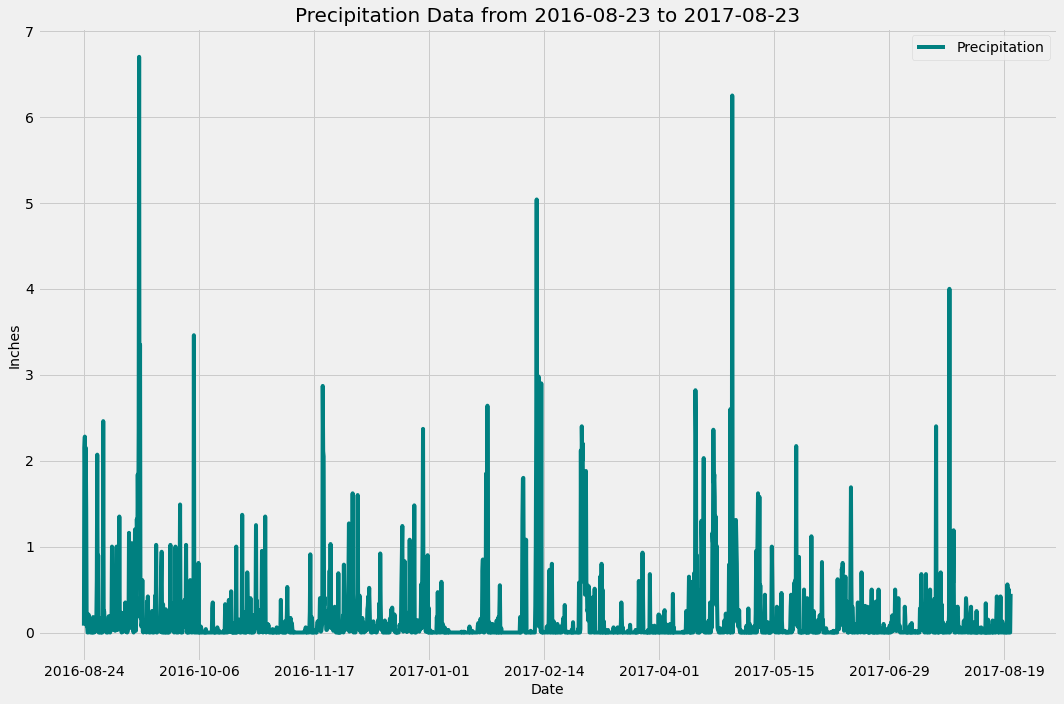

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(color="teal", figsize=(15, 10),)

plt.xlabel('Date', fontsize = 14)
plt.ylabel('Inches', fontsize = 14)
plt.title('Precipitation Data from 2016-08-23 to 2017-08-23', fontsize = 20)

plt.tight_layout()

plt.savefig("./Images/One_year_precipitation.png")


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

# Station Analysis

1. Design a query to calculate the total number of stations in the dataset.

2. Design a query to find the most active stations (i.e. which stations have the most rows?).

3. List the stations and observation counts in descending order.

4. Which station id has the highest number of observations?

5. Using the most active station id, calculate the lowest, highest, and average temperature. (Use functions: func.min, func.max, func.avg, and func.count in your queries).

6. Design a query to retrieve the last 12 months of temperature observation data (TOBS).

7. Filter by the station with the highest number of observations.

8. Query the last 12 months of temperature observation data for this station.

9. Plot the results as a histogram with bins=12.

In [21]:
# Design a query to calculate the total number stations in the dataset

station_count = session.query(Station).count()

print(f"The number of active stations is {station_count}")

The number of active stations is 9


In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# Day 03-Act-11-Stu_Chinook - Documentation: https://stackoverflow.com/questions/370174/sqlalchemy-with-count-group-by-and-order-by-using-the-orm

active_station = session.query(Measurement.station, Station.name, func.count(Measurement.id)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).all()

# https://docs.python.org/3/library/pprint.html

print(f"The most active stations are:")
pprint(active_station)


The most active stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [23]:
# Which station id has the highest number of observations?
Highest_obs = session.query(Measurement.station, Station.name, func.count(Measurement.id)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).first()
Highest_obs

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [24]:
#  Query the dates and temperature observations of the most active station for the last year of data.

active_results = (
    session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between ("2016-08-23", "2017-08-23")).all()
)
# active_results

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_record = (
    session.query(
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    )
    .filter(Measurement.station == active_station[0][0]).all()
)

station_record

print(f"The minimum temperature is {station_record[0][0]} °F")
print(f"The average temperature is {round(station_record[0][1],1)} °F")
print(f"The maximum temperature is {station_record[0][2]} °F")

The minimum temperature is 54.0 °F
The average temperature is 71.7 °F
The maximum temperature is 85.0 °F


In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temperature_results = (
    session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > last_year_date).\
    filter(Measurement.station == active_station[0][0]).\
    order_by(Measurement.date).all()
)
# temperature_results

In [27]:
# ALL VARIABLES IN ONE

# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
# last_date

# Calculate the date one year from the last date in data set.
last_year_date = last_date - dt.timedelta(days=365)
# last_year_date

active_station = session.query(Measurement.station, Station.name, func.count(Measurement.id)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).all()
# active_station

temperature_results = (
    session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > last_year_date).\
    filter(Measurement.station == active_station[0][0]).\
    order_by(Measurement.date).all()
)
# temperature_results

In [28]:
# Convert the query object temperature_results into dataframe
temperature_df = pd.DataFrame(temperature_results).set_index('date').sort_index(ascending=True)
temperature_df

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


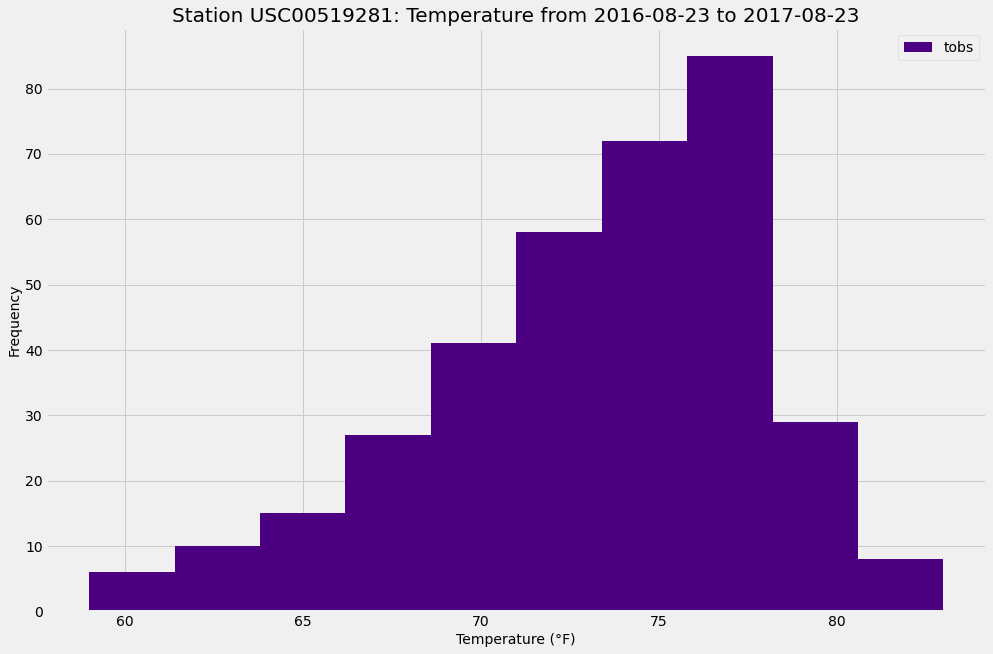

In [29]:
# Query the last 12 months of temperature observation data for this station (temperature_df)
# and plot the results as a histogram
temperature_df.plot(kind= 'hist', color= 'indigo', figsize=(15, 10))

plt.xlabel('Temperature (°F)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Station USC00519281: Temperature from 2016-08-23 to 2017-08-23', fontsize = 20)

plt.savefig("./Images/Temperature_station_USC00519281.png")

# Close session

In [30]:
# Close Session
session.close()